In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
dataset = datasets.FashionMNIST(
    root="./data", train=True, download=False, transform=transforms.ToTensor()
)

In [4]:
dataset[0][0].shape

torch.Size([1, 28, 28])

In [5]:
dataset[0][0].view((28, 28, -1)).shape

torch.Size([28, 28, 1])

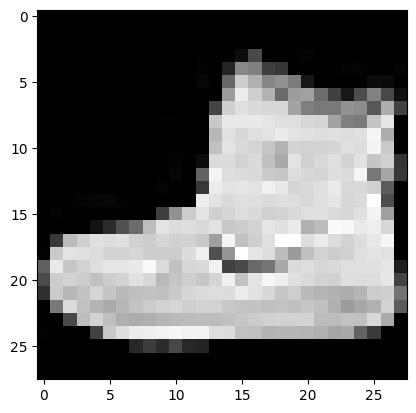

In [6]:
plt.imshow(dataset[0][0].permute(1, 2, 0), cmap='gray');

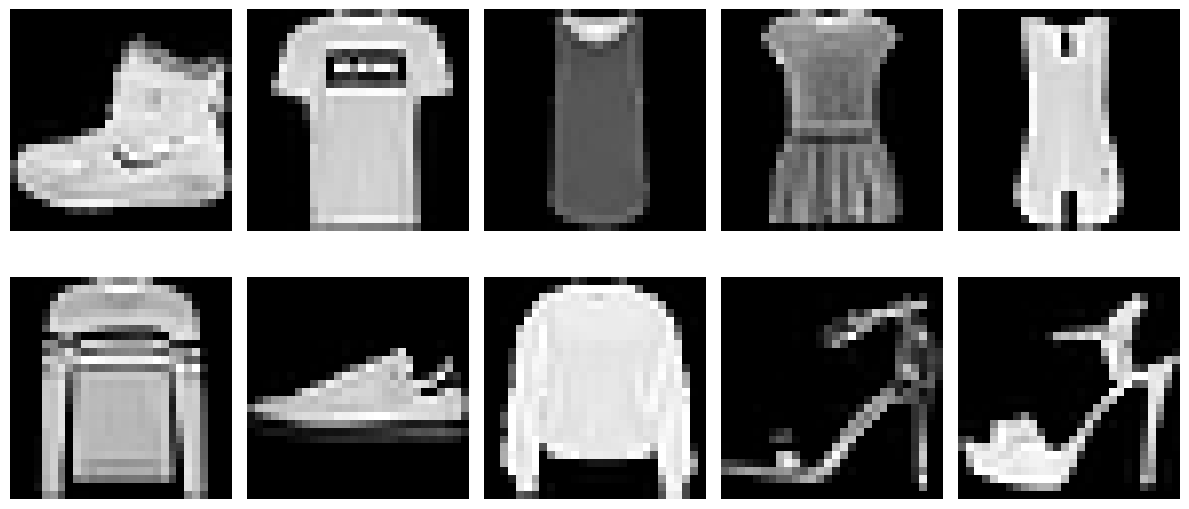

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    img, _ = dataset[i]
    ax.imshow(img.permute(1, 2, 0), cmap='gray');
    ax.axis("off")

plt.tight_layout()

In [8]:
LABEL_COLOR_MAP = {
    0: (1.0, 0.3, 0.3),
    1: (0.3, 1.0, 0.3),
    2: (0.3, 0.3, 1.0),
    3: (1.0, 0.5, 0.0),
    4: (0.6, 0.2, 0.8),
    5: (1.0, 1.0, 0.0),
    6: (0.0, 1.0, 1.0),
    7: (1.0, 0.2, 0.6),
    8: (0.5, 0.5, 0.5),
    9: (0.8, 0.8, 0.2),
}

def colorize_grayscale(img, label):
    """Convert a 1-channel grayscale image to a 3-channel RGB image based on label."""
    r, g, b = LABEL_COLOR_MAP[label]  # Get RGB color
    img = img.expand(3, -1, -1)  # Convert (1, H, W) to (3, H, W)

    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    img[0] *= r  # Apply red component
    img[1] *= g  # Apply green component
    img[2] *= b  # Apply blue component

    img = torch.clamp(img, 0, 1)

    return img

In [9]:
class ColorizedFashionMNIST(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset  # Original dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]  # Get original grayscale image & label
        img = colorize_grayscale(img, label)  # Apply colorization
        return img, label  # Return colorized image & label
    
colorized_dataset = ColorizedFashionMNIST(dataset)

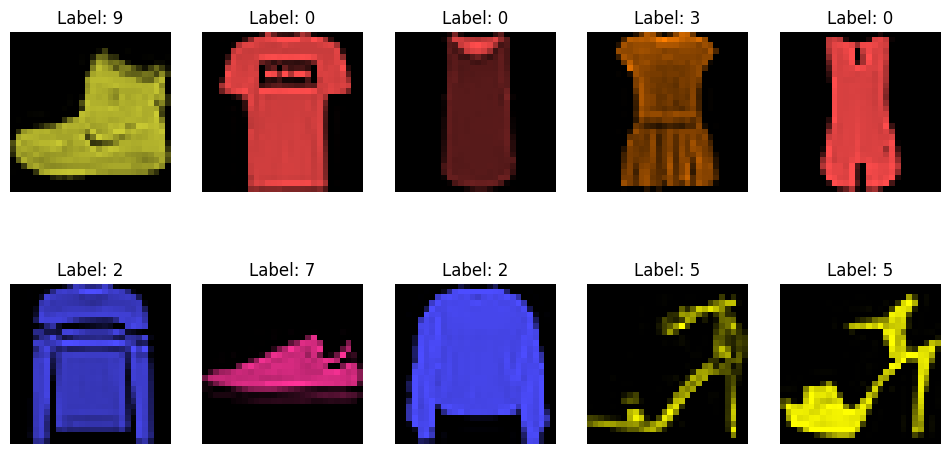

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    img, label = colorized_dataset[i]  # Get colored image & label
    ax.imshow(img.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    ax.set_title(f"Label: {label}")  # Show class label
    ax.axis("off")

In [11]:
dataloader = DataLoader(colorized_dataset, batch_size=128, shuffle=True)

In [12]:
next(iter(dataloader))[0].shape

torch.Size([128, 3, 28, 28])

In [13]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_logvar = nn.Linear(128 * 3 * 3, latent_dim)

    def forward(self, x):
        out = self.conv(x)
        out = torch.flatten(out, 1)
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)
        return mu, logvar


mu, logvar = Encoder()(next(iter(dataloader))[0])
mu.shape, logvar.shape

(torch.Size([128, 128]), torch.Size([128, 128]))

In [14]:
# input torch.Size([128, 3, 28, 28])

# conv32 torch.Size([128, 28, 14, 14])
# conv64 torch.Size([128, 64, 7, 7])
# conv128 torch.Size([128, 128, 3, 3])

# mu/logvar [torch.Size([128, 128]), torch.Size([128, 128])]

In [15]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 3 * 3)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        x = self.fc(z).view(-1, 128, 3, 3)
        x = self.deconv(x)
        return x

In [16]:
Decoder()(mu).shape

torch.Size([128, 3, 28, 28])

In [17]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [18]:
VAE()(next(iter(dataloader))[0])[0].detach().shape

torch.Size([128, 3, 28, 28])

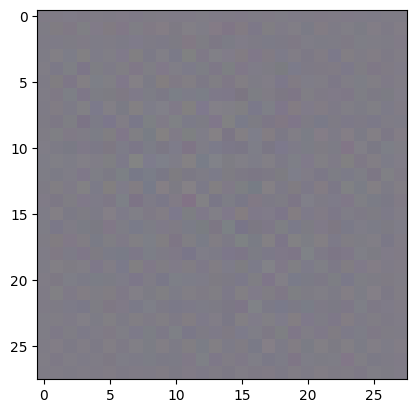

In [19]:
plt.imshow(VAE()(next(iter(dataloader))[0])[0][0].detach().permute(1, 2, 0));

In [20]:
# Loss function
def loss_function(x_recon, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [21]:
vae = VAE(latent_dim=128).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [22]:
num_epochs = 20
for epoch in range(num_epochs):
    vae.train()
    total_loss = 0
    for x, _ in tqdm(dataloader, leave = False):
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        loss = loss_function(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader.dataset):.4f}")

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, Loss: 85.8000


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, Loss: 41.9381


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, Loss: 37.2859


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, Loss: 35.4618


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, Loss: 34.4545


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, Loss: 33.7567


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, Loss: 33.2908


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, Loss: 32.8523


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, Loss: 32.4945


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, Loss: 32.2572


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, Loss: 32.0288


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, Loss: 31.8171


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, Loss: 31.6036


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, Loss: 31.4805


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, Loss: 31.3528


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16, Loss: 31.1966


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, Loss: 31.1170


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, Loss: 30.9498


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, Loss: 30.8363


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, Loss: 30.7679


In [53]:
img = next(iter(dataloader))[0][0]

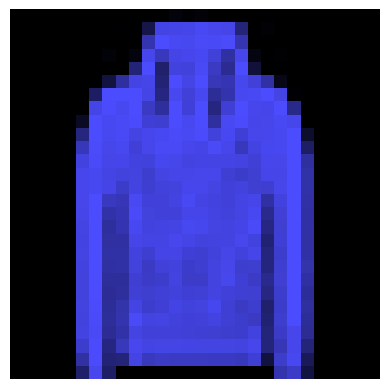

In [55]:
plt.imshow(img.permute(1, 2, 0))
# just image no axis
plt.axis("off")
plt.savefig("img")

In [56]:
img = img.to(device).unsqueeze(0)
# get latent space
mu, logvar = vae.encoder(img)
latent = vae.reparameterize(mu, logvar)
latent.shape

torch.Size([1, 128])

In [66]:
plt.imshow(latent.cpu().detach().view(-1, 1)[:50])
plt.axis("off")

(-0.5, 0.5, 49.5, -0.5)

(-0.5, 27.5, 27.5, -0.5)

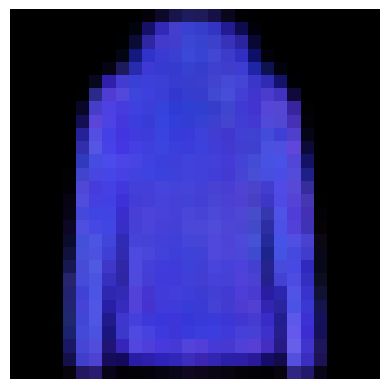

In [68]:
recon = vae.decoder(latent)
plt.imshow(recon.cpu().detach().view(3, 28, 28).permute(1, 2, 0))
plt.axis("off")

In [69]:
# radom sample from latent space
latent = torch.randn(1, 128).to(device)
# show the first 50 values
plt.imshow(latent.cpu().detach().view(-1, 1)[:50])
plt.axis("off")

(-0.5, 0.5, 49.5, -0.5)

(-0.5, 27.5, 27.5, -0.5)

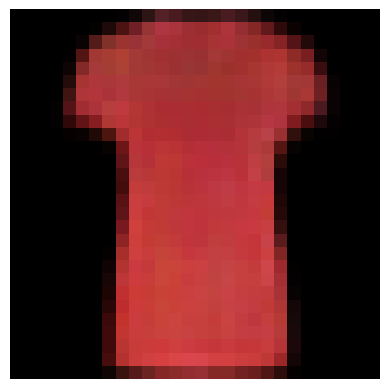

In [70]:
recon = vae.decoder(latent)
plt.imshow(recon.cpu().detach().view(3, 28, 28).permute(1, 2, 0))
plt.axis("off")

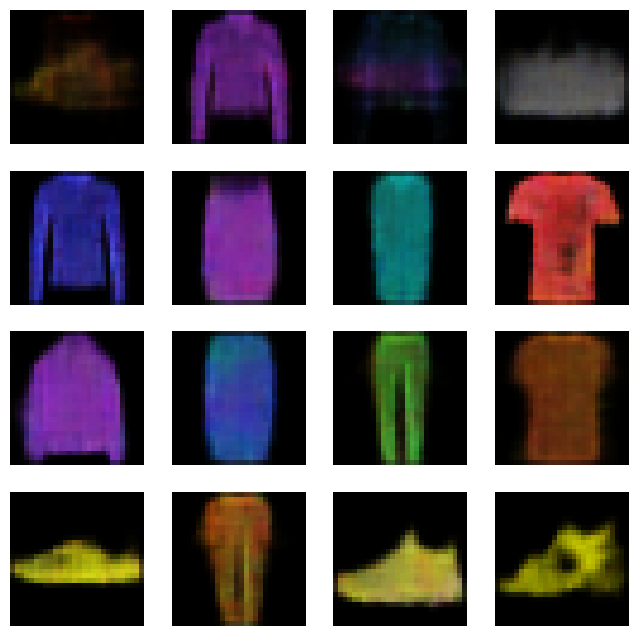

In [73]:
vae.eval()
with torch.no_grad():
    z = torch.randn(16, 128).to(device)  # Sample from normal distribution
    generated_images = vae.decoder(z)

# Move to CPU for visualization
generated_images = generated_images.cpu()

# Plot generated images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].squeeze().permute(1, 2, 0), cmap="gray")
    ax.axis("off");